##   Social Networks: The Tracking of COVID-19 Misinformation Using NLP and Graph-based Approaches

1. What kinds of users participate in the dissemination of misinformation?
2. What Natural Language Processing (NLP) based patterns can be drawn from malicious users and their tweets/posts?
3. How is misinformation propagated in terms of a longitudinal time frame?
4. What are noticeable differences and similarities in how misinformation spreads between Reddit and Twitter?

###  Environment Configuration

In [1]:
import pandas as pd
import plotly.express as px 
import pandas as pd 
from collections import Counter
from tqdm import tqdm
import os 
from wordcloud import WordCloud, STOPWORDS
import networkx as nx
import ast
import powerlaw
tqdm.pandas()

In [4]:
months = {
    # '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October'
    # '11': 'November',
    # '12': 'December'
}

In [5]:
def load_dataset() -> pd.DataFrame:
    # Load initial dataset to dataframe
    tweets = pd.read_parquet('datasets\\UPDATED_vaccine_tweets.parquet.gzip')
    # Extract Month from Date Column and Convert into Month Only
    tweets_ts= tweets['date'].progress_apply(lambda x: months[x[5:7]])
    # Apply New Date Format to Dataframe
    tweets['date'] = tweets_ts
    return tweets

### Tweet Visualizations

In [6]:
tweets = load_dataset()
tweets.head()

100%|██████████| 209929/209929 [00:00<00:00, 973261.79it/s]


,id,conversation_id,created_at,date,time,timezone,user_id,username,name,place,...,user_rt_id,user_rt,retweet_id,reply_to,retweet_date,translate,trans_src,trans_dest,sentiment,validity
0,1319174447442448384,1319153697406906369,2020-10-22 12:41:12 India Standard Time,October,12:41:12,530,270371054,to_fly_to_live,Flynn Rider,None,...,NaN,NaN,NaN,['@ANI'],NaN,NaN,NaN,NaN,negative,Contains Misinformation
1,1319174381503852544,1319174381503852544,2020-10-22 12:40:56 India Standard Time,October,12:40:56,530,864189073858084864,utkarshsinha07,Utkarsh Sinha,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,neutral,No Misinformation
2,1319174114779643905,1319174114779643905,2020-10-22 12:39:52 India Standard Time,October,12:39:52,530,116114711,batolebazi,BATOLEBAZI,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,neutral,Contains Misinformation
3,1319174091232833536,1319172728851591174,2020-10-22 12:39:47 India Standard Time,October,12:39:47,530,1249338116,bak_sahil,sahil,None,...,NaN,NaN,NaN,['@MisseeMonis'],NaN,NaN,NaN,NaN,neutral,No Misinformation
4,1319174029488476160,1319174029488476160,2020-10-22 12:39:32 India Standard Time,October,12:39:32,530,804225890062319617,ivibhatweedy,𝐯𝐢𝐛𝐬 | 🐺,None,...,NaN,NaN,NaN,[],NaN,NaN,NaN,NaN,negative,No Misinformation


In [7]:
def plot_monthly_activity() -> None:   
    timeseries = dict.fromkeys(months.values(), 0)

    for month in months.values():
        ts_month = tweets.loc[tweets['date'] == month]
        timeseries[month] = len(ts_month) 
    print(timeseries)
    fig = px.bar(
        x = timeseries.keys(),
        y = timeseries.values(),
        labels = {
            'x': 'Months',
            'y': 'Count'
        }
    )
    fig.show()




In [8]:
def plot_sentiment_of_month(month:str) -> None:
    tbm = tweets.loc[tweets['date'] == month]
    sentiment = Counter(tbm['sentiment'])
    fig = px.pie(
        data_frame = tbm,
        names = sentiment.keys(),
        values = sentiment.values()
    )
    fig.show()
    

In [9]:
def plot_validity_of_month(month:str) -> None:
    tbm = tweets.loc[tweets['date'] == month]
    validity = Counter(tbm['validity'])
    fig = px.pie(
        data_frame = tbm,
        names = validity.keys(), 
        values = validity.values()
        )
    fig.show()

In [10]:
def plot_hashtags_of_month(month: str) -> None:
    timeseries = dict.fromkeys(months.keys(), 0)
    ts_month = tweets.loc[tweets['date'] == month]
    hashtags = []
    for entry in ts_month['hashtags']:
        if str(entry).strip() != 'None':
            hashtags += ast.literal_eval(entry.lower())
        else:
            hashtags.append('none')
    hashtag_count = Counter(hashtags)
    hashtags = dict(hashtag_count.most_common(10))
    fig = px.bar(
        data_frame = ts_month,
        y = hashtags.keys(),
        x = hashtags.values(),
        labels = {
            'y': 'Hashtag',
            'x': 'Count'
        },
        orientation = 'h'
    )
    fig.show()



In [11]:
def plot_posting_users_of_month(month: str) -> None:
    tbm = tweets.loc[tweets['date'] == month]
    users = dict(Counter(tbm['username']).most_common(10))
    fig = px.bar(
        x = users.keys(),
        y = users.values(),
        labels = {
            'x': 'Usernames (@)',
            'y': 'Number of Posts'
        }
    )
    fig.show()

In [28]:
def plot_tagged_users_of_month(month: str) -> None:
    tbm = tweets.loc[tweets['date'] == month]
    top_users = Counter(tbm['reply_to']).most_common(11)
    print(top_users)
    users = {}
    for entry in top_users:
        if ast.literal_eval(entry[0]) != list():
            users[entry[0]] = entry[1]
    fig = px.bar(
        x = users.keys(),
        y = users.values(),
        labels = {
            'x': 'Usernames (@)',
            'y': 'Number of Mentions'
        },
    )
    fig.show()


In [13]:
plot_monthly_activity()

{'February': 65, 'March': 2259, 'April': 9102, 'May': 15084, 'June': 12266, 'July': 35849, 'August': 48098, 'September': 55458, 'October': 31748}


In [14]:
plot_sentiment_of_month('April')

In [15]:
plot_validity_of_month('April')

In [16]:
plot_hashtags_of_month('April')

In [17]:
plot_posting_users_of_month('April')

In [29]:
plot_tagged_users_of_month('February')

[('[]', 31), ("['@FeralJack_']", 1), ("['@MwangP01', '@chothep', '@StandardKenya', '@ayogo_do', '@MaMo_', '@Luther_Gen', '@BasilioCC', '@Abdysoh2', '@YussufMwinyi', '@SolomonKarori2', '@WilsonWaGitau', '@Moha001_Onyango']", 1), ("['@Tiresias999', '@cwarzel', '@realDonaldTrump']", 1), ("['@Brasilmagic']", 1), ("['@CJBowden1', '@StirringTrouble']", 1), ("['@BDSmovement']", 1), ("['@JustFollowingP3', '@morphonios']", 1), ("['@revmagdalen', '@koolkaryn']", 1), ("['@phlogga']", 1), ("['@catherinefloydd']", 1)]


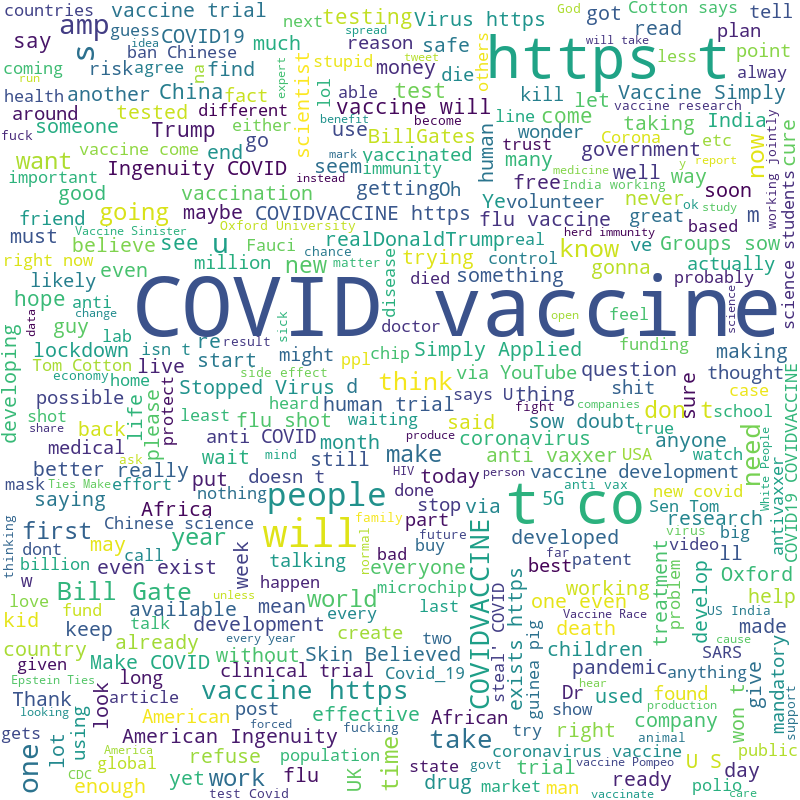

In [203]:
tbm = tweets.loc[tweets['date'] == 'April']
wv_all_tweets = WordCloud(
    background_color='white',
    width=800,
    height=800,
    stopwords=set(STOPWORDS),
    max_words=1000,
    min_font_size=12,
    random_state=2
    )
wv_all_tweets.generate(' '.join(tbm['tweet']))
wv_all_tweets.to_image()

### Graph Visualizations

In [2]:
G = nx.read_gexf('gexf\\vaccine_tweets_whole_graph.gexf')

In [27]:
def power_law_distribution(G: nx.DiGraph):
  # If the majority of the scatter is a straight line, we are straight vibin'

  degrees = []
  power_fit = powerlaw.Fit([x[1] for x in G.degree])
  for node, degree in G.degree:
    degrees.append(degree)
  degrees = Counter(degrees)
  fig = px.scatter(
    x = degrees.keys(),
    y = degrees.values(),
    title = f'Log Distribution of Graph (Alpha = {round(power_fit.alpha, 2)})',
    labels = {
      'x': 'Node Degree',
      'y': 'Probability: p(k) = P(X = k)'
    }
  )
  fig.update_xaxes(type='log')
  fig.update_yaxes(type='log')
  fig.show()

In [28]:
power_law_distribution(G)

Calculating best minimal value for power law fit


In [23]:
def general_network_properties(G: nx.DiGraph) -> None:
  print(f"Average Clustering Coefficient is {round(nx.average_clustering(G), 4)}")
  top_k_scored_users = sorted(nx.pagerank(G).items(), key = lambda x:x[1], reverse=True)
  hubs = sorted(nx.hits(G)[0].items(), key = lambda x:x[1], reverse=True)
  authorities = sorted(nx.hits(G)[1].items(), key = lambda x:x[1], reverse=True)

  max_threshold = 10 # @param {type:"number"}
  print(f"Top {max_threshold} Pagerank Users in the Graph")
  for i in range(max_threshold):
    print(f"\tUser {top_k_scored_users[i][0]} has score contribution {round(top_k_scored_users[i][1], 4)}")
  print(f"Top {max_threshold} Hub Users")
  for i in range(max_threshold):
     print(f"\tUser {hubs[i][0]} has score contribution {round(hubs[i][1], 4)}")
  print(f"Top {max_threshold} Authority Users")
  for i in range(max_threshold):
     print(f"\tUser {authorities[i][0]} has score contribution {round(authorities[i][1], 4)}")

In [25]:
general_network_properties(G)

Average Clustering Coefficient is 0.0066
Top 10 Pagerank Users in the Graph
	User realDonaldTrump has score contribution 0.01
	User YouTube has score contribution 0.0064
	User MailOnline has score contribution 0.0019
	User narendramodi has score contribution 0.0018
	User JoeBiden has score contribution 0.0015
	User CNN has score contribution 0.0011
	User WHO has score contribution 0.001
	User gatewaypundit has score contribution 0.001
	User BillGates has score contribution 0.0009
	User PMOIndia has score contribution 0.0009
Top 10 Hub Users
	User jcho710 has score contribution 0.0005
	User jpatte8007 has score contribution 0.0004
	User cheese24k has score contribution 0.0004
	User thedaily1birdy has score contribution 0.0003
	User anne4189 has score contribution 0.0003
	User arumughamvinu has score contribution 0.0003
	User jurg_ames has score contribution 0.0003
	User bosa6688 has score contribution 0.0003
	User lifeispietzsche has score contribution 0.0003
	User mal1976retaf has scor